In [9]:
from mpi4py import MPI
import gmsh
import numpy as np
from scipy.spatial import cKDTree
import pyvista as pv
from dolfinx import plot

Lx, Ly = 1.0, 1.0

In [10]:
from dolfinx import mesh, fem
import ufl
import numpy as np
from dolfinx.io import gmsh as gmshio
from mpi4py import MPI

# ---------------------------------------------------------------------
# 1. Mesh and tags (same mesh as reference)
# ---------------------------------------------------------------------
ref = 4
filename = f"regular_mesh_{ref}.msh"
msh, cell_markers, facet_markers = gmshio.read_from_msh(filename, MPI.COMM_WORLD, 0, gdim=2)[0:3]

tdim = msh.topology.dim  # 2
fdim = tdim - 1          # 1

lc = 1.0 / (2**ref)      # mesh size
h = lc

omega = msh

# ---------------------------------------------------------------------
# 2. Function space (standard CG on the bulk only)
# ---------------------------------------------------------------------
order = 1
V = fem.functionspace(omega, ("Lagrange", order))

# ---------------------------------------------------------------------
# 3. Trial / Test / Solution function
# ---------------------------------------------------------------------
phi = ufl.TestFunction(V)
p = fem.Function(V, name="p")
dp = ufl.TrialFunction(V)

# ---------------------------------------------------------------------
# 4. Coordinates and data
# ---------------------------------------------------------------------
x = ufl.SpatialCoordinate(omega)
# f_m = fem.Constant(omega, 0.0)
# f_m = 2*(x[1] - x[1]**2 + x[0] - x[0]**2)
f_m = x[1]
def f_callable(x):
    return x[1]

f = fem.Function(V)
f.interpolate(f_callable)
# create function
k_m = fem.Function(V, name="kappa")

def k_callable(x):
    # x is array with shape (gdim, N). compute scalar per point, return shape (1,N)
    vals = 2*(x[0])
    return vals[np.newaxis, :]

k_m.interpolate(k_callable)

kappa = 1.0
# k_m = fem.Constant(omega, kappa)  # bulk permeability

dx = ufl.Measure("dx", domain=omega)

# compute domain bbox to locate sides
coords = omega.geometry.x
xx = coords[:, 0]
yy = coords[:, 1]
xmin, xmax = xx.min(), xx.max()
ymin, ymax = yy.min(), yy.max()

tol = 1e-10 * max(xmax - xmin, ymax - ymin)

# locate boundary facets for bottom (y = ymin) and top (y = ymax)
bottom_facets = mesh.locate_entities_boundary(
    omega, fdim, lambda x: np.isclose(x[1], ymin, atol=tol)
)
top_facets = mesh.locate_entities_boundary(
    omega, fdim, lambda x: np.isclose(x[1], ymax, atol=tol)
)

# create meshtags for those Neumann parts (optional — kept for clarity)
indices = np.concatenate([bottom_facets, top_facets]).astype(np.int32)
values = np.concatenate([
    np.full(bottom_facets.shape, 10, dtype=np.int32),  # bottom tag = 10
    np.full(top_facets.shape,    20, dtype=np.int32),  # top tag    = 20
])
neumann_tags = mesh.meshtags(omega, fdim, indices, values)

# boundary measure (we'll use ds over the whole boundary with conditional g_N)
dsN = ufl.Measure("ds", domain=omega)  # we integrate g_N over the boundary

# Neumann data as conditional on the y coordinate (same as reference)
# g_N = ufl.conditional(
#     ufl.lt(abs(x[1] - ymax), tol),
#     -1.0,                                # top
#     ufl.conditional(
#         ufl.lt(abs(x[1] - ymin), tol),
#         2.0,                             # bottom
#         0.0                              # elsewhere
#     ),
# )

# ---------------------------------------------------------------------
# 5. Weak form (standard Darcy / Poisson form)
# ---------------------------------------------------------------------
a = ufl.inner(k_m * ufl.grad(dp), ufl.grad(phi)) * dx
L = f_m * phi * dx
# L -= g_N * phi * dsN

# Form for assembling (bilinear/trilinear functions expect TrialFunction in a)
A_form = ufl.inner(k_m * ufl.grad(dp), ufl.grad(phi)) * dx
b_form = L

# ---------------------------------------------------------------------
# 6. Dirichlet BCs (left/right like reference)
# ---------------------------------------------------------------------
# locate dofs on each side
left_dofs   = fem.locate_dofs_geometrical(V, lambda x: np.isclose(x[0], xmin, atol=tol))
right_dofs  = fem.locate_dofs_geometrical(V, lambda x: np.isclose(x[0], xmax, atol=tol))
top_dofs  = fem.locate_dofs_geometrical(V, lambda x: np.isclose(x[1], ymax, atol=tol))
bottom_dofs  = fem.locate_dofs_geometrical(V, lambda x: np.isclose(x[1], ymin, atol=tol))

all_dofs = np.unique(np.concatenate([left_dofs, right_dofs]))
dof_coords = V.tabulate_dof_coordinates()

p_bc_fun = fem.Function(V)
p_bc_fun.x.array[left_dofs] = 0.0
p_bc_fun.x.array[right_dofs] = dof_coords[right_dofs, 1] / 2.0
# p_bc_fun.x.array[top_dofs] = 0.0
# p_bc_fun.x.array[bottom_dofs] = 0.0

bc = fem.dirichletbc(p_bc_fun, all_dofs)
bcs = [bc]

# ---------------------------------------------------------------------
# 7. Solve linear problem using dolfinx.fem.petsc.LinearProblem
# ---------------------------------------------------------------------
from dolfinx.fem import petsc

linear_problem = petsc.LinearProblem(
    a=A_form,
    L=b_form,
    bcs=bcs,
    petsc_options={
        "ksp_type": "preonly",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
        "ksp_error_if_not_converged": True,
    },
    petsc_options_prefix="pmix_"
)

p_sol = linear_problem.solve()
p_sol.name = "pressure"

# optionally copy into p Function if you prefer
p.x.array[:] = p_sol.x.array[:]

# ---------------------------------------------------------------------
# 8. Diagnostics
# ---------------------------------------------------------------------
print("DOFs in V:", V.dofmap.index_map.size_global)


Info    : Reading 'regular_mesh_4.msh'...
Info    : 2337 entities
Info    : 289 nodes
Info    : 2337 elements
Info    : Done reading 'regular_mesh_4.msh'
DOFs in V: 289


In [11]:
# Access mesh geometry
tdim = omega.topology.dim

# Gather coordinates and connectivity
omega_geometry = omega.geometry.x[:,0:2]  # global array of vertex coords
# Build cell->vertex mapping (fast access)
# Using dolfinx.Cell to get connectivity is more robust, but below uses mesh.topology
cells = omega.topology.connectivity(0, tdim)  # vertices -> cells
# Instead get cell->vertex mapping via mesh.topology.index_map?
# Simpler: use mesh.geometry.x with mesh.topology.connectivity(tdim, 0)
ctv = omega.topology.connectivity(tdim, 0)
if ctv is None:
    omega.topology.create_connectivity(tdim, 0)
    ctv = omega.topology.connectivity(tdim, 0)
# ctv.array() gives flattened vertex indices -> need per-cell view
# There's a helper to get cell entity indices
num_cells = omega.topology.index_map(tdim).size_local  # per-rank local count
# We'll iterate over local cells only
local_cells = np.arange(num_cells, dtype=np.int32)

# For evaluating u_h and kappa, we can use u_h.x.array if needed.
# But easier: create a point evaluation lambda to get value at a point
from dolfinx.fem import Function
u_func = p_sol
local_fluxes = {}
V_dofmap = V.dofmap.index_map.local_range  # not directly used; we'll query dofs per cell

# Get dof indices per cell
# Using dolfinx.fem.locate_dofs_topological is one option, but below we get cell_dofs
dofmap = V.dofmap
# But to avoid uncertain reshape semantics, use mesh.topology.connectivity(tdim, 0).entities
# Simpler robust approach: use dolfinx.mesh.cells() to get local cells vertex indices
try:
    from dolfinx.mesh import cells as dolfinx_cells
    local_cell_vertices = dolfinx_cells(mesh)
except Exception:
    # fallback: create by slicing connectivity
    # arr = ctv.array
    # local_cell_vertices = arr.reshape((-1, 3))
    local_cell_vertices = np.array([ctv.links(c) for c in range(ctv.num_nodes)])

In [18]:
import numpy as np
import torch
import torch.nn as nn
import cma
from tqdm import tqdm
import basix
from dolfinx import default_scalar_type, mesh as dmesh
import math

# ---------------------------------------------------------
# 1. Define a small NN for flux (or flux correction)
# ---------------------------------------------------------

class FluxNet(nn.Module):
    def __init__(self, in_dim=1, out_dim=1, hidden_dim=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, out_dim),
        )

    def forward(self, x):
        # x: tensor of shape (N, in_dim)
        return self.net(x)


net = FluxNet(in_dim=2, out_dim=2, hidden_dim=16)


# ---------------------------------------------------------
# 2. Utilities to flatten / unflatten parameters
# ---------------------------------------------------------

def get_flat_params_from(net: nn.Module) -> np.ndarray:
    """
    Returns a 1D numpy array containing all parameters of the network.
    """
    with torch.no_grad():
        vec = torch.nn.utils.parameters_to_vector(net.parameters())
    return vec.cpu().numpy()


def set_flat_params_to(net: nn.Module, theta: np.ndarray):
    """
    Loads a 1D numpy array `theta` back into the network parameters.
    """
    theta_torch = torch.tensor(theta, dtype=torch.float32)
    with torch.no_grad():
        torch.nn.utils.vector_to_parameters(theta_torch, net.parameters())


# ---------------------------------------------------------
# 3. Define a loss function for CMA-ES (gradient-free)
# ---------------------------------------------------------

# Precompute sample points (these play the role of quadrature points)
# x_np = np.linspace(0.0, 1.0, 128, endpoint=True)
x_np = V.tabulate_dof_coordinates()
x_torch = torch.tensor(x_np, dtype=torch.float32).view(-1, 1)


def compute_flux_loss(net: nn.Module, it=None) -> torch.Tensor:
    """
    L = sum_j ( ∫_{∂D_j} r_θ · n  +  ∫_{∂D_j} q_cg · n  -  ∫_{D_j} f )^2

    - r_θ: NN-based flux correction (evaluated by manual quadrature, order >= 2)
    - q_cg: local CG flux, recomputed on the one-cell local mesh
    - f:    source term, integrated over the one-cell local mesh

    This version is FULLY autograd-compatible w.r.t. net.parameters,
    so you can use Adam / SGD, e.g.:

        loss = compute_flux_loss(net)
        loss.backward()
        optimizer.step()
    """
    device = next(net.parameters()).device
    gdim = omega_geometry.shape[1]

    # 2-point Gauss–Legendre rule on [0,1] (order >= 2, exact up to degree 3)
    xi = torch.tensor(
        [
            0.5 * (1.0 - 1.0 / math.sqrt(3.0)),
            0.5 * (1.0 + 1.0 / math.sqrt(3.0)),
        ],
        dtype=torch.float32,
        device=device,
    )
    wi = torch.tensor([0.5, 0.5], dtype=torch.float32, device=device)

    # Accumulate loss as a torch scalar (keep autograd graph)
    total_loss = torch.zeros((), dtype=torch.float32, device=device)

    for local_cell_idx, cell_verts in enumerate(local_cell_vertices):
        # -------------------------------------------------
        # 1. Build one-cell local mesh for this element
        # -------------------------------------------------
        coords = omega_geometry[cell_verts]  # numpy, shape (3, gdim)
        centroid = np.mean(coords, axis=0).reshape(1,-1)
        
        loc_cells = np.array([[0, 1, 2]], dtype=np.int64)

        coord_el = basix.ufl.element(
            "Lagrange", "triangle", 1, shape=(gdim,)
        )

        local_mesh = dmesh.create_mesh(
            MPI.COMM_SELF, loc_cells, coord_el, coords
        )

        # -------------------------------------------------
        # 2. Local FE spaces (scalar CG(order), vector CG(order+1))
        # -------------------------------------------------
        # Vector-valued correction space (for r_θ)
        V_loc = fem.functionspace(local_mesh, ("CG", order + 1, (gdim,)))
        # r_loc = fem.Function(V_loc)

        # Scalar space (for p_K, k_m_loc, f_m_loc)
        P_loc = fem.functionspace(local_mesh, ("CG", order))
        p_K = fem.Function(P_loc)
        k_m_loc = fem.Function(P_loc)
        f_m_loc = fem.Function(P_loc)

        # -------------------------------------------------
        # 3. Interpolate NN into r_loc via dof coordinates
        #    (we DON'T use fem.assemble for r_θ; we integrate manually)
        # -------------------------------------------------
        x_loc = V_loc.tabulate_dof_coordinates()[:, 0:2]  # (Ndofs, gdim)
        x_loc_torch = torch.tensor(x_loc, dtype=torch.float32, device=device)

        # Evaluate NN at all dofs (autograd ON)
        r_vals_torch = net(x_loc_torch)                   # (Ndofs, gdim)
        # r_vals = r_vals_torch.detach().cpu().numpy().reshape(-1)

        # Assign to r_loc (this is just for consistency; r_loc isn't used in integration now)
        # r_loc.x.array[:] = r_vals.astype(default_scalar_type)

        # -------------------------------------------------
        # 4. Manual quadrature for ∫_{∂D_j} r_θ · n ds
        # -------------------------------------------------
        coords_t = torch.tensor(coords, dtype=torch.float32, device=device)

        edge_indices = [(0, 1), (1, 2), (2, 0)]
        int_r_local = torch.zeros((), dtype=torch.float32, device=device)
        num_sub = 3

        for (i0, i1) in edge_indices:
            x0 = coords_t[i0]  # (2,)
            x1 = coords_t[i1]  # (2,)
            t = x1 - x0        # tangent
            L = torch.linalg.norm(t)
            if L <= 0:
                continue

            # Outward normal for CCW triangle: rotate tangent by -90°
            n_edge = torch.stack([t[1], -t[0]]) / L  # (2,)
            centroid_t = torch.tensor(centroid, dtype=n_edge.dtype, device=n_edge.device).squeeze()
            midpoint = 0.5 * (x0 + x1)
            if np.dot(n_edge, (centroid_t - midpoint)) > 0:
                n_edge = -n_edge

            # 🔑 composite Gauss–Legendre in s ∈ [0,1]
            h = 1.0 / num_sub

            for j in range(num_sub):  # loop over subintervals
                s_left = j * h
                # s_right = (j + 1) * h  # not needed explicitly

                for k in range(len(xi)):  # Gauss points on [0,1]
                    s = s_left + h * xi[k]   # 🔑 mapped Gauss point in [s_left, s_right]
                    w = h * wi[k]            # 🔑 scaled weight for this subinterval

                    x_q = x0 + s * t         # point on edge in R^2
                    x_q_torch = x_q.unsqueeze(0)

                    r_q = net(x_q_torch)[0]  # NN flux at x_q

                    contrib = torch.dot(r_q, n_edge) * L * w
                    int_r_local = int_r_local + contrib

        # -------------------------------------------------
        # 5. Compute ∫_{∂D_j} q_cg · n and ∫_{D_j} f via FEM
        #    (they do NOT depend on net, so autograd is unaffected)
        # -------------------------------------------------
        # Map global DOFs -> local DOFs
        global_dofs = V.dofmap.cell_dofs(local_cell_idx)
        local_dofs = P_loc.dofmap.cell_dofs(0)

        # Pressure p_K
        p_K.x.array[local_dofs] = p_sol.x.array[global_dofs]
        p_K.x.scatter_forward()

        # Permeability k_m_loc
        k_m_loc.x.array[local_dofs] = k_m.x.array[global_dofs]
        k_m_loc.x.scatter_forward()

        # Source f_m_loc
        f_m_loc.x.array[local_dofs] = f.x.array[global_dofs]
        f_m_loc.x.scatter_forward()

        # q_cg = -k_m_loc * grad(p_K)
        q_CG = -k_m_loc * ufl.grad(p_K)
        n_K = ufl.FacetNormal(local_mesh)

        int_qcg = fem.assemble_scalar(
            fem.form(ufl.dot(q_CG, n_K) * ufl.ds(domain=local_mesh))
        )  # Python float
        int_f = fem.assemble_scalar(
            fem.form(f_m_loc * ufl.dx(domain=local_mesh))
        )  # Python float

        int_qcg_t = torch.tensor(float(int_qcg), dtype=torch.float32, device=device)
        int_f_t   = torch.tensor(float(int_f),   dtype=torch.float32, device=device)

        # -------------------------------------------------
        # 6. Cell residual and loss accumulation
        # -------------------------------------------------
        residual_j = int_r_local + int_qcg_t - int_f_t
        total_loss = total_loss + residual_j**2

    # total_loss is a torch scalar, suitable for autograd
    return total_loss


# ---------------------------------------------------------
# 4. Train the network with Adam (gradient-based)
# ---------------------------------------------------------
# import torch

# Put network on desired device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)

# Adam optimizer
learning_rate = 1e-3
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

max_epochs = 320    # or whatever you like
mse_it = []

best_loss = float("inf")
best_state = None

for epoch in range(max_epochs):
    net.train()
    optimizer.zero_grad()

    loss = compute_flux_loss(net, epoch)

    loss.backward()
    optimizer.step()

    loss_value = float(loss.item())
    mse_it.append(loss_value)

    # 🔑 save best model
    if loss_value < best_loss:
        best_loss = loss_value
        best_state = {k: v.detach().clone() for k, v in net.state_dict().items()}

    if epoch % 10 == 0:
        print(f"[Epoch {epoch:4d}] loss = {loss_value:.6e}")

# 🔑 restore best parameters after training
net.load_state_dict(best_state)


print("Training finished. Final loss:", best_loss)


/tmp/ipykernel_59070/2307905051.py:162: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  if np.dot(n_edge, (centroid_t - midpoint)) > 0:


[Epoch    0] loss = 7.625916e-03
[Epoch   10] loss = 7.056383e-03
[Epoch   20] loss = 6.570217e-03
[Epoch   30] loss = 6.174238e-03
[Epoch   40] loss = 5.877867e-03
[Epoch   50] loss = 5.674293e-03
[Epoch   60] loss = 5.526566e-03
[Epoch   70] loss = 5.393721e-03
[Epoch   80] loss = 5.258871e-03
[Epoch   90] loss = 5.120282e-03
[Epoch  100] loss = 4.976137e-03
[Epoch  110] loss = 4.823461e-03
[Epoch  120] loss = 4.660397e-03
[Epoch  130] loss = 4.485937e-03
[Epoch  140] loss = 4.299314e-03
[Epoch  150] loss = 4.100163e-03
[Epoch  160] loss = 3.888682e-03
[Epoch  170] loss = 3.665984e-03
[Epoch  180] loss = 3.434830e-03
[Epoch  190] loss = 3.200780e-03
[Epoch  200] loss = 2.973063e-03
[Epoch  210] loss = 2.763173e-03
[Epoch  220] loss = 2.580718e-03
[Epoch  230] loss = 2.429161e-03
[Epoch  240] loss = 2.304687e-03
[Epoch  250] loss = 2.198713e-03
[Epoch  260] loss = 2.102715e-03
[Epoch  270] loss = 2.011662e-03
[Epoch  280] loss = 1.923570e-03
[Epoch  290] loss = 1.837380e-03
[Epoch  30

In [23]:
torch.save(best_state, "best_model_tanh.pt")

In [24]:
sum(p.numel() for p in net.parameters())


354

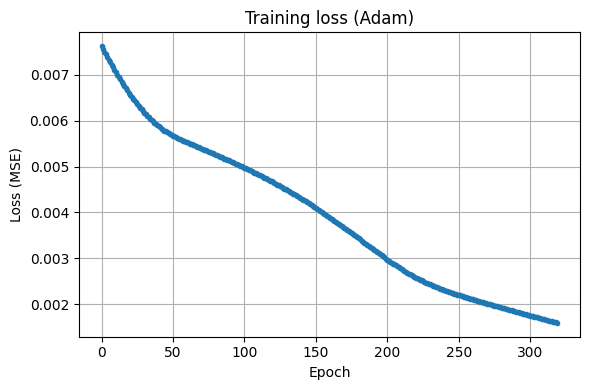

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(mse_it, marker="o", markersize=3)
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training loss (Adam)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
LCE_CG = []
LCE_rec = []
indices = []

LCE_CG_int = []
LCE_rec_int = []
indices_int = []
for local_cell_idx, cell_verts in enumerate(tqdm(local_cell_vertices)):
    # cell_verts are global vertex indices
    coords = omega_geometry[cell_verts]  # shape (3,2)
    centroid = np.mean(coords, axis=0).reshape(1,-1)

    loc_cells = np.array([[0, 1, 2]], dtype=np.int64)

    gdim = coords.shape[1]
    coord_el = basix.ufl.element("Lagrange", "triangle", 1, shape=(gdim,))

    local_mesh = dmesh.create_mesh(
        MPI.COMM_SELF,
        loc_cells,
        coord_el,   # <-- this is the required "e" argument
        coords
    )
    cell_dofs = V.dofmap.cell_dofs(local_cell_idx)
    # -------------------------------------------------
    # 2. Local vector CG2 space for r_θ
    # -------------------------------------------------
    # Vector-valued CG2 (shape=(gdim,))
    V_loc = fem.functionspace(local_mesh, ("CG", order+1, (gdim,)))
    r_loc = fem.Function(V_loc)

    # -------------------------------------------------
    # 3. Interpolate NN into r_loc via dof coordinates
    # -------------------------------------------------
    x_loc = V_loc.tabulate_dof_coordinates()[:,0:2]  # (Ndofs, gdim)
    x_loc_torch = torch.tensor(x_loc, dtype=torch.float32)      # NN input

    r_vals_torch = net(x_loc_torch)                             # (Ndofs, gdim)
    r_vals = r_vals_torch.detach().cpu().numpy().reshape(-1)

    # assign to local FEM function
    r_loc.x.array[:] = r_vals.astype(default_scalar_type)

    # -------------------------------------------------
    # 4. Compute ∫_{∂D_j} r_θ · n ds on local mesh
    # -------------------------------------------------
    n_K = ufl.FacetNormal(local_mesh)
    int_r_form = fem.form(ufl.dot(r_loc, n_K) * ufl.ds)
    int_r_local = fem.assemble_scalar(int_r_form)

    # -------------------------------------------------
    # 5. Combine with q_cg and f (precomputed per cell)
    # -------------------------------------------------
    P_loc = fem.functionspace(local_mesh, ("CG", order))
    p_K = fem.Function(P_loc)

    # DOFs on this cell in the global space
    global_dofs = V.dofmap.cell_dofs(local_cell_idx)

    # DOFs on the (only) cell in the local space
    local_dofs = P_loc.dofmap.cell_dofs(0)

    p_K.x.array[local_dofs] = p_sol.x.array[global_dofs]
    p_K.x.scatter_forward()

    k_m_loc = fem.Function(P_loc)
    k_m_loc.x.array[local_dofs] = k_m.x.array[global_dofs]

    q_CG = -k_m_loc * ufl.grad(p_K)
    int_qcg = fem.assemble_scalar(
                fem.form(ufl.dot(q_CG, n_K) * ufl.ds(domain=local_mesh))
            )   # ∫_{∂D_j} q_cg · n
    
    f_m_loc = fem.Function(P_loc)
    f_m_loc.x.array[local_dofs] = f.x.array[global_dofs]
    f_m_loc.x.scatter_forward()
    int_f   = fem.assemble_scalar(fem.form(f_m_loc * ufl.dx(domain=local_mesh)))       # ∫_{D_j} f

    residual_j = int_r_local + int_qcg - int_f

    LCE_CG.append(int_qcg - int_f)
    LCE_rec.append(residual_j)
    indices.append(local_cell_idx)

    left_dofs_P = fem.locate_dofs_geometrical(
        P_loc, lambda x: np.isclose(x[0], xmin, atol=tol)
    )
    right_dofs_P = fem.locate_dofs_geometrical(
        P_loc, lambda x: np.isclose(x[0], xmax, atol=tol)
    )

    if (len(left_dofs_P) == 0) and (len(right_dofs_P) == 0):
        LCE_CG_int.append(int_qcg - int_f)
        LCE_rec_int.append(residual_j)
        indices_int.append(local_cell_idx)

  0%|          | 0/512 [00:00<?, ?it/s]

100%|██████████| 512/512 [00:05<00:00, 98.94it/s] 


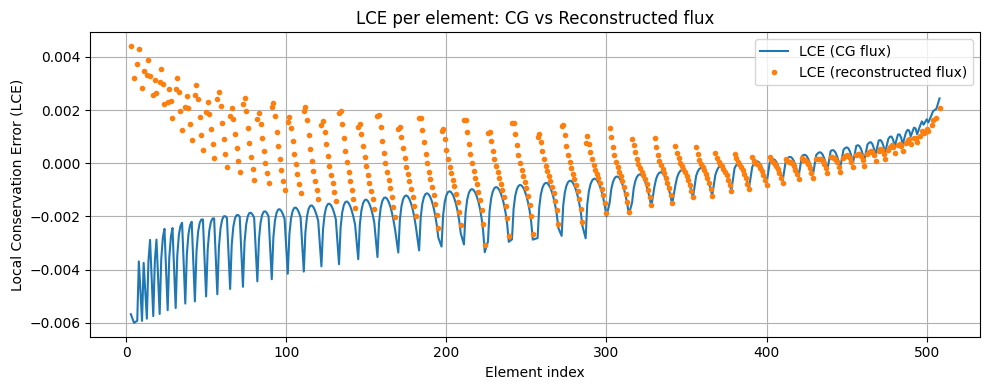

CG LCE stats: {'min': -0.006003117505676121, 'max': 0.002438592789572943, 'L1_mean_abs': 0.001492693584011395, 'L2_rms': 0.0019014356027301429}
Reconstructed LCE stats: {'min': -0.003086562521875241, 'max': 0.004401531159101717, 'L1_mean_abs': 0.0009365930951609668, 'L2_rms': 0.0012490690754866911}


In [21]:

indices_plot = np.array(indices_int, dtype=int)
LCE_CG_plot = np.array(LCE_CG_int, dtype=float)
LCE_rec_plot = np.array(LCE_rec_int, dtype=float)

# plot
plt.figure(figsize=(10,4))
plt.plot(indices_plot, LCE_CG_plot, label="LCE (CG flux)")
plt.plot(indices_plot, LCE_rec_plot, ".", label="LCE (reconstructed flux)")
plt.xlabel("Element index")
plt.ylabel("Local Conservation Error (LCE)")
plt.title("LCE per element: CG vs Reconstructed flux")
plt.legend()
plt.grid(True)
plt.tight_layout()
# out_path = "/mnt/data/lce_plot.png"
# plt.savefig(out_path)
plt.show()

# print stats & produce dataframe
def stats(arr):
    return {"min": float(arr.min()), "max": float(arr.max()), "L1_mean_abs": float(np.mean(np.abs(arr))), "L2_rms": float(np.sqrt(np.mean(arr**2)))}
print("CG LCE stats:", stats(LCE_CG_plot))
print("Reconstructed LCE stats:", stats(LCE_rec_plot))

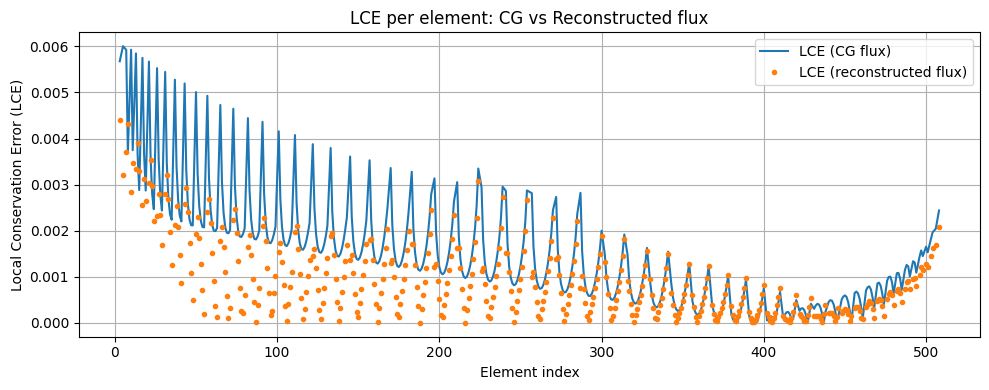

CG LCE stats: {'min': -0.006003117505676121, 'max': 0.002438592789572943, 'L1_mean_abs': 0.001492693584011395, 'L2_rms': 0.0019014356027301429}
Reconstructed LCE stats: {'min': -0.003086562521875241, 'max': 0.004401531159101717, 'L1_mean_abs': 0.0009365930951609668, 'L2_rms': 0.0012490690754866911}


In [22]:
import matplotlib.pyplot as plt
indices_plot = np.array(indices_int, dtype=int)
LCE_CG_plot = np.array(LCE_CG_int, dtype=float)
LCE_rec_plot = np.array(LCE_rec_int, dtype=float)

# plot
plt.figure(figsize=(10,4))
plt.plot(indices_plot, np.abs(LCE_CG_plot), label="LCE (CG flux)")
plt.plot(indices_plot, np.abs(LCE_rec_plot), ".", label="LCE (reconstructed flux)")
plt.xlabel("Element index")
plt.ylabel("Local Conservation Error (LCE)")
plt.title("LCE per element: CG vs Reconstructed flux")
plt.legend()
plt.grid(True)
plt.tight_layout()
# out_path = "/mnt/data/lce_plot.png"
# plt.savefig(out_path)
plt.show()

# print stats & produce dataframe
def stats(arr):
    return {"min": float(arr.min()), "max": float(arr.max()), "L1_mean_abs": float(np.mean(np.abs(arr))), "L2_rms": float(np.sqrt(np.mean(arr**2)))}
print("CG LCE stats:", stats(LCE_CG_plot))
print("Reconstructed LCE stats:", stats(LCE_rec_plot))